# Misinformation Diffusion Analysis
Full Research + Presentation Version (English)

## Introduction
This notebook analyzes tipping-point dynamics of misinformation diffusion on ER and BA networks using agent-based simulations.

In [10]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random
import os

# Create results folders
os.makedirs("results/plots", exist_ok=True)
os.makedirs("results/csv", exist_ok=True)



In [11]:
def build_er_network(n=2000, p_edge=0.01):
    return nx.erdos_renyi_graph(n, p_edge)

def build_ba_network(n=2000, m=3):
    return nx.barabasi_albert_graph(n, m)


In [12]:
def simulate_diffusion(G, p, num_rounds=10):
    infected = set([random.choice(list(G.nodes()))])  # seed node
    
    for _ in range(num_rounds):
        new_infected = set(infected)
        for node in infected:
            for nbr in G.neighbors(node):
                if nbr not in infected:
                    if random.random() < p:
                        new_infected.add(nbr)
        infected = new_infected

    return len(infected) / len(G.nodes())



In [13]:
def sweep_probabilities(G, p_values, runs=20):
    results = []
    for p in p_values:
        avg = np.mean([simulate_diffusion(G, p) for _ in range(runs)])
        results.append(avg)
    return results


In [14]:
def logistic(p, alpha, p0):
    return 1 / (1 + np.exp(-alpha * (p - p0)))


In [15]:
def fit_logistic(p_values, adoption_rates):
    params, _ = curve_fit(logistic, p_values, adoption_rates, p0=[10, 0.2])
    alpha, p0 = params
    return alpha, p0


In [16]:
def compute_tipping(p_values, adoption_rates, threshold=0.8):
    for p, a in zip(p_values, adoption_rates):
        if a >= threshold:
            return p
    return None



In [17]:
def clustering_vs_tipping(G, p_values):
    clustering = nx.average_clustering(G)
    adoption_rates = sweep_probabilities(G, p_values)
    tipping = compute_tipping(p_values, adoption_rates)
    return clustering, tipping


In [18]:
p_values = [i/100 for i in range(1, 40)]

# Build networks
ER = build_er_network()
BA = build_ba_network()

# Run adoption curves
A_er = sweep_probabilities(ER, p_values)
A_ba = sweep_probabilities(BA, p_values)



In [19]:
df_er = pd.DataFrame({"p": p_values, "A_ER": A_er})
df_er.to_csv("results/csv/er_adoption_curve.csv", index=False)



In [20]:
df_ba = pd.DataFrame({"p": p_values, "A_BA": A_ba})
df_ba.to_csv("results/csv/ba_adoption_curve.csv", index=False)


In [21]:
df_compare = pd.DataFrame({
    "p": p_values,
    "ER": A_er,
    "BA": A_ba
})
df_compare.to_csv("results/csv/er_vs_ba.csv", index=False)


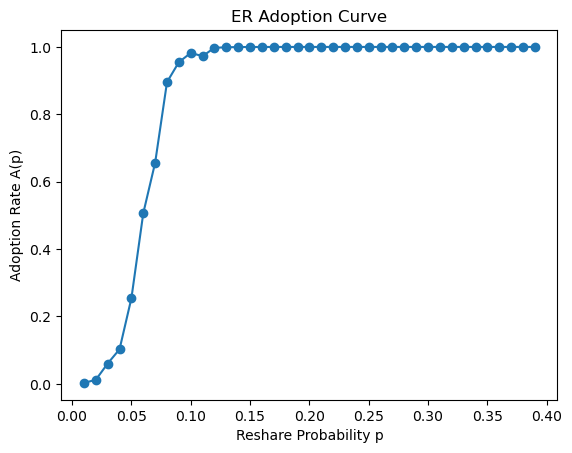

In [22]:
plt.figure()
plt.plot(p_values, A_er, marker='o')
plt.title("ER Adoption Curve")
plt.xlabel("Reshare Probability p")
plt.ylabel("Adoption Rate A(p)")
plt.savefig("results/plots/er_adoption_curve.png", dpi=300)
plt.show()


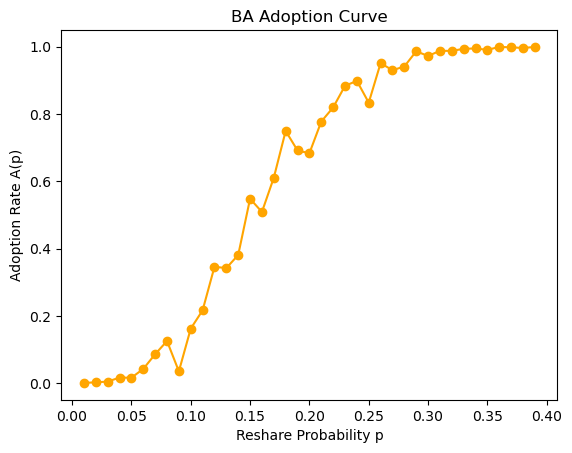

In [23]:
plt.figure()
plt.plot(p_values, A_ba, marker='o', color='orange')
plt.title("BA Adoption Curve")
plt.xlabel("Reshare Probability p")
plt.ylabel("Adoption Rate A(p)")
plt.savefig("results/plots/ba_adoption_curve.png", dpi=300)
plt.show()


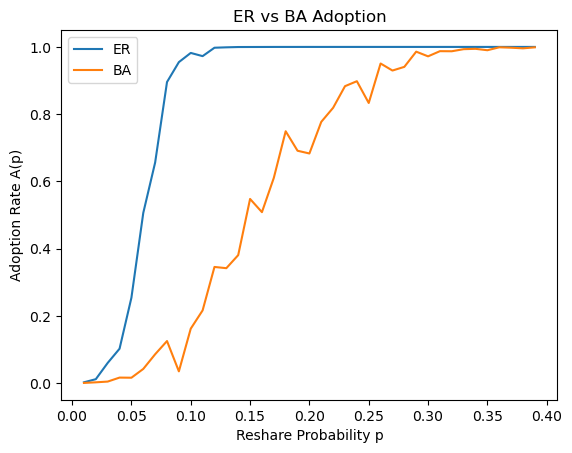

In [24]:
plt.figure()
plt.plot(p_values, A_er, label="ER")
plt.plot(p_values, A_ba, label="BA")
plt.legend()
plt.title("ER vs BA Adoption")
plt.xlabel("Reshare Probability p")
plt.ylabel("Adoption Rate A(p)")
plt.savefig("results/plots/er_vs_ba.png", dpi=300)
plt.show()


In [25]:
alpha_er, p0_er = fit_logistic(p_values, A_er)
alpha_ba, p0_ba = fit_logistic(p_values, A_ba)

df_logistic = pd.DataFrame({
    "network": ["ER", "BA"],
    "alpha": [alpha_er, alpha_ba],
    "p0 (tipping)": [p0_er, p0_ba]
})

df_logistic.to_csv("results/csv/logistic_fit_parameters.csv", index=False)
df_logistic


,network,alpha,p0 (tipping)
0,ER,97.255391,0.060964
1,BA,26.542022,0.156306


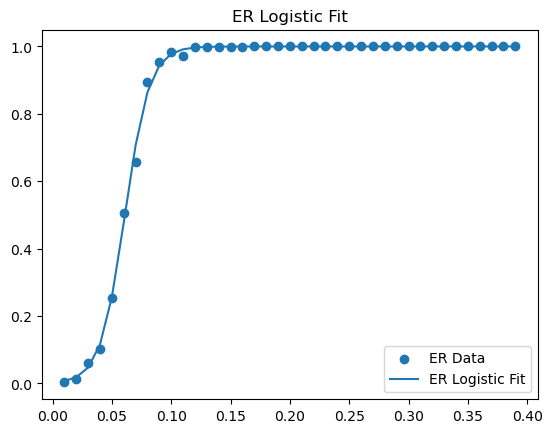

In [26]:
plt.figure()
plt.scatter(p_values, A_er, label="ER Data")
plt.plot(p_values, logistic(np.array(p_values), alpha_er, p0_er), label="ER Logistic Fit")
plt.legend()
plt.title("ER Logistic Fit")
plt.savefig("results/plots/er_logistic_fit.png", dpi=300)
plt.show()


In [27]:
C_er, tip_er = clustering_vs_tipping(ER, p_values)
C_ba, tip_ba = clustering_vs_tipping(BA, p_values)

df_cluster = pd.DataFrame({
    "network": ["ER", "BA"],
    "clustering": [C_er, C_ba],
    "tipping_point": [tip_er, tip_ba]
})
df_cluster.to_csv("results/csv/clustering_vs_tipping.csv", index=False)
df_cluster


,network,clustering,tipping_point
0,ER,0.010339,0.08
1,BA,0.018365,0.23


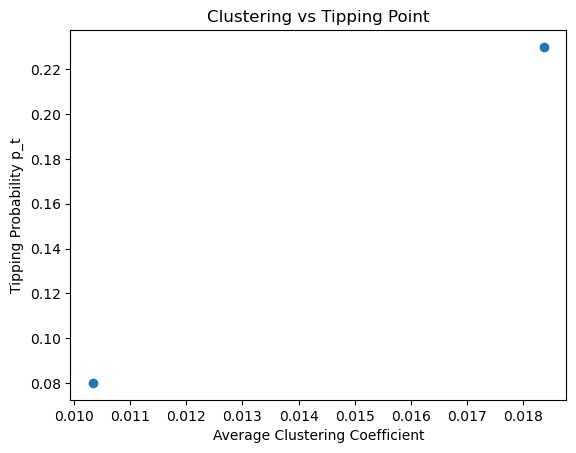

In [28]:
plt.figure()
plt.scatter([C_er, C_ba], [tip_er, tip_ba])
plt.title("Clustering vs Tipping Point")
plt.xlabel("Average Clustering Coefficient")
plt.ylabel("Tipping Probability p_t")
plt.savefig("results/plots/clustering_vs_tipping.png", dpi=300)
plt.show()
